<center>

**Feature engineering** 

</center>
    
This step involves creating new features from existing ones, selecting relevant features, reducing dimensionality or complexity of the data, etc. This step enhances the data by adding more information and reducing noise or redundancy. Some common feature engineering techniques are :

- Feature creation: Generating new features from existing ones using mathematical operations, domain knowledge, or external sources.
- Feature selection: Choosing the most relevant and informative features for the problem or question using methods such as filter methods (based on statistical measures), wrapper methods (based on model performance), or embedded methods (based on model coefficients).
- Feature extraction: Reducing the dimensionality or complexity of the data by transforming the original features into a lower-dimensional space using methods such as principal component analysis (PCA), linear discriminant analysis (LDA), or autoencoders.




# Personal view

The most common feature that help in detection of heart desease are:

- **chest pain type:**

It is not a good **indicator** to show CAD diseases becasue of in the different syptoms, the majority of its values tend to give **no disease**

![chest pain type-count_plot.jpg](attachment:e93895e5-5eb5-4ac4-84da-fd0a88c5f179.jpg)

- **exercise induced angina**

It is a good **indicator** to show CAD diseases becasue the **No** value gives bigger priority for no CAD diseases

![exercise induced angina-count_plot.jpg](attachment:99b9579c-6696-4935-8414-e819fd42d893.jpg)

- **the slop of ST segment**

It is a good **indicator** to show CAD diseases becasue there its values help in distinguishing if there is CAD diseases.

![slope peak exercise ST segment-count_plot.jpg](attachment:966df1dc-b2cb-40b8-a763-0317036a6ad7.jpg)
![download.png](attachment:76589c46-b978-4f07-891a-8c56f7f0e131.png)

- **thallium stress result:**

the flow of blood to your heart through your coronary arteries, An abnormal test result can reveal coronary blockages as well as damage from heart attacks

It is a good **indicator**

![thallium stress result-count_plot.jpg](attachment:8e68998b-05a6-4dc2-bd1c-f6dca054b5f1.jpg)

- **max heart rate**
- **age**
- **ST depression**


In [1]:
PROC_TRAIN_DATA_PATH = "../../data/processed/preprocessed_train_data.pkl"
FIG_DIR = "../../reports/figures/"


# Import packages


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import Union, Callable

# Import estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from genetic_selection import GeneticSelectionCV


# Import features selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    RFECV,
    SequentialFeatureSelector,
    SelectKBest,
    SelectFromModel,
)

from skfeature.function.similarity_based.fisher_score import fisher_score

from mlxtend.feature_selection import SequentialFeatureSelector as mlx_sfs
from mlxtend.plotting import plot_sequential_feature_selection

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Import tunning hyper parameters methods
from sklearn.model_selection import GridSearchCV

# from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# Import resampling methods
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler

import warnings

warnings.filterwarnings("ignore")


In [3]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)


# Read data


In [4]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)
X, y = df_train.iloc[:, :-1], df_train["target"]

num_cols = [
    "age",
    "resting_blood_pressure",
    "serum_cholestoral",
    "maximum_heart_rate",
    "ST_depression",
]
cat_cols = set(X.columns.to_list()) - set(num_cols)
cat_cols = list(cat_cols)


In [5]:
df_train.head()


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic,maximum_heart_rate,exercise_induced_angina,ST_depression,slope_peak_exercise_ST_segment,number_of_major_vessels,thallium_stress_result,target
155,51.0,1.0,4.0,140.0,299.0,0.0,0.0,173.0,1.0,1.6,1.0,0.0,7.0,1
10,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,0
53,60.0,1.0,4.0,130.0,253.0,0.0,0.0,144.0,1.0,1.4,1.0,1.0,7.0,1
122,55.0,1.0,4.0,140.0,217.0,0.0,0.0,111.0,1.0,5.6,3.0,0.0,7.0,3
208,62.0,0.0,4.0,150.0,244.0,0.0,0.0,154.0,1.0,1.4,2.0,0.0,3.0,1


# Selection


#### Drawing test scores (bar plot)


In [6]:
@dataclass
class RankResult:
    """class for storing test results"""

    specs: list[str]
    scores: list[Union[int, float]]
    data: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self):
        # Grouping results in DataFrame
        self.data = pd.DataFrame()
        self.data["Spec"] = self.specs
        self.data["Score"] = self.scores


@dataclass
class FeatureRank:
    """Class holding feature ranking from the ranking method"""

    score_func: Callable[[pd.DataFrame, pd.DataFrame], list[int]]
    rank_result: RankResult = field(init=False)

    def get_ranks(self, X: pd.DataFrame, y: pd.DataFrame):
        # Calculate feature ranking
        ret = self.score_func(X.to_numpy(), y.to_numpy())

        # Create test data
        scores = ret[0] if (len(ret) == 2) else ret

        # Normalize scores
        scores = (scores - scores.min()) / (scores.max() - scores.min())

        self.rank_result = RankResult(specs=X.columns, scores=scores)

        # Change the index of the DataFrame
        self.rank_result.data.index = [
            X.columns.get_loc(spec) for spec in self.rank_result.data["Spec"]
        ]

        return self

    def get_largest_score(self, num_feats: int = None) -> list[str]:
        """Get the largest ranks of features

        Args:
            n (Union[int, str], optional): number of features to get. Defaults to 'auto'.

        Returns:
            list[str]: list of n largest features' ranks
        """
        if not num_feats:
            num_feats = self.rank_result.data.shape[0]

        return self.rank_result.data.nlargest(n=num_feats, columns=["Score"])[
            "Spec"
        ].values.tolist()

    def plot_scores(self, title, sorting=False, save=False):
        """Plot feature importance as bar plot"""

        # Take copy of data to avoid modifying on original data
        data = self.rank_result.data.copy()

        if sorting:
            data = data.sort_values(by="Score", ascending=False)

        fig = plt.figure(figsize=(20, 12))
        ax = fig.add_subplot()
        axs = sns.barplot(
            y="Spec", x="Score", data=data, palette="Greens_r", orient="h", ax=ax
        )

        plt.box(False)

        ax.set_title(title, fontsize=20)

        ax.set_xlabel("Importance \n", fontsize=20)
        ax.set_ylabel("\n Features", fontsize=20)

        ax.tick_params(axis="x", labelsize=24)
        ax.tick_params(axis="y", labelsize=20)

        ax.bar_label(ax.containers[0], fontsize=18, padding=10)
        sns.set_style("ticks", {"axes.grid": True})

        if save:
            fig.savefig(
                fname=FIG_DIR + f"features_selection/{title}.jpg", bbox_inches="tight"
            )

        return ax


### Filter methods

The current problem contains independent features with categorical target. <br>
Therefore the desired filter methods to be used are **Chi2** and **LDA**:

1. For measuring the independence between Continues features and categorical target, The LDA algorithm should be used because:

   - LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

2. For measuring the independence between categorical features and categorical target, The chi2 test should be used because:
   - Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.


#### Correlation


<AxesSubplot:>

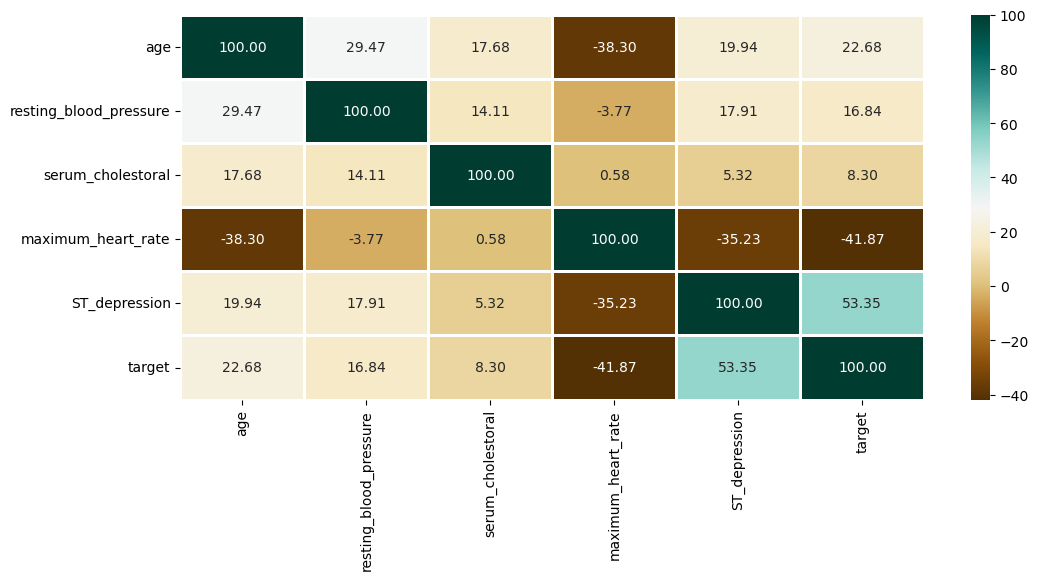

In [7]:
corr_values = df_train[num_cols + ["target"]].corr()

plt.figure(figsize=(12, 5))
sns.heatmap(
    corr_values * 100,
    linecolor="w",
    linewidths=1,
    annot=True,
    fmt=".2f",
    cmap=plt.cm.BrBG,
)


#### Multicollinearity Detecting

Variable Inflation Factors (VIF):

- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


In [8]:
vif = pd.DataFrame()
vif_corr_values = df_train[num_cols].corr()
vif["variables"] = vif_corr_values.columns
vif["VIF"] = [
    variance_inflation_factor(vif_corr_values.values, i)
    for i in range(vif_corr_values.shape[1])
]
vif


,variables,VIF
0,age,2.800337
1,resting_blood_pressure,1.691991
2,serum_cholestoral,1.214511
3,maximum_heart_rate,2.775888
4,ST_depression,1.906737


#### Information Gain


<AxesSubplot:title={'center':'Information gain - features importance'}, xlabel='Importance \n', ylabel='\n Features'>

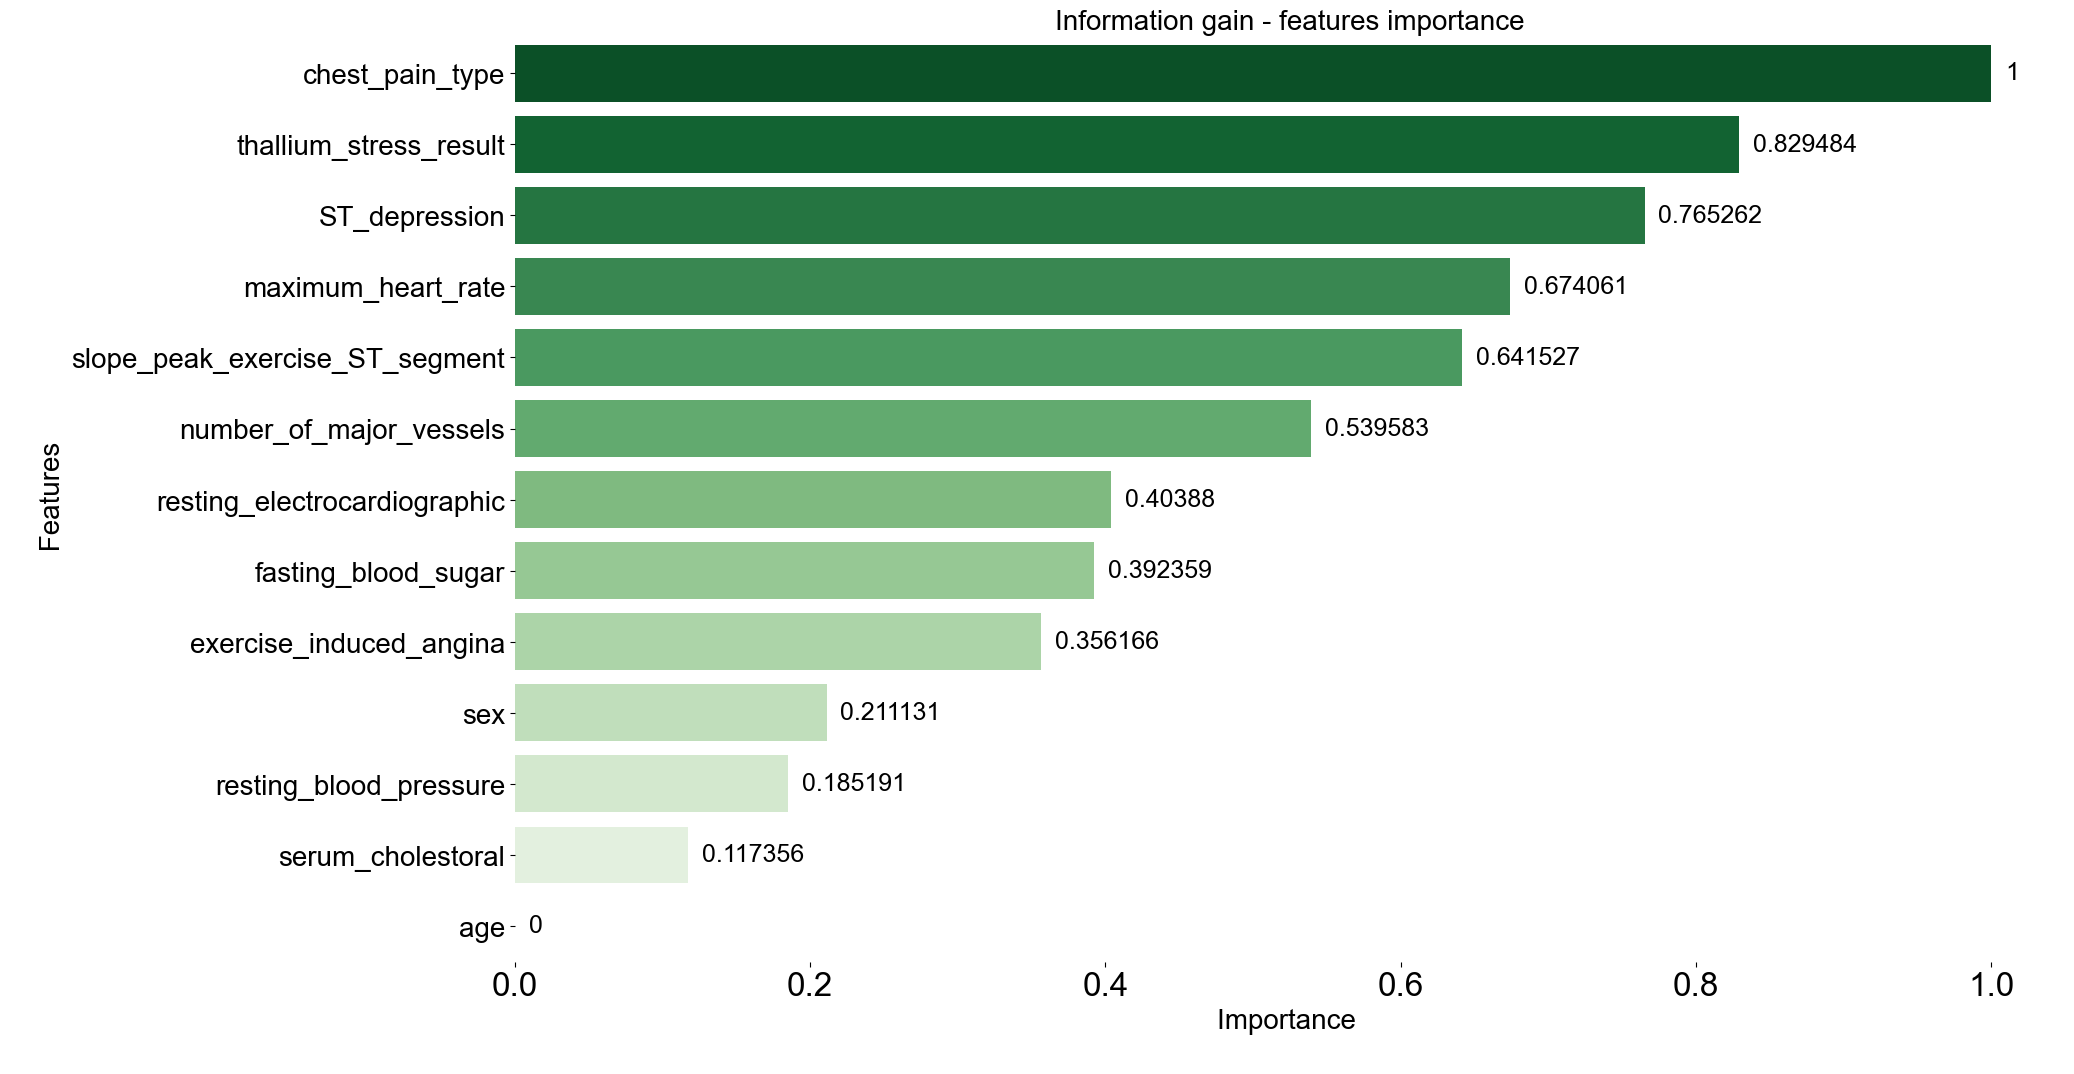

In [9]:
mutual_info_rank = FeatureRank(mutual_info_classif).get_ranks(X, y)
mutual_info_rank.plot_scores(
    "Information gain - features importance", sorting=True, save=True
)


#### Fisher's Score


<AxesSubplot:title={'center':'Fisher Score - features importance'}, xlabel='Importance \n', ylabel='\n Features'>

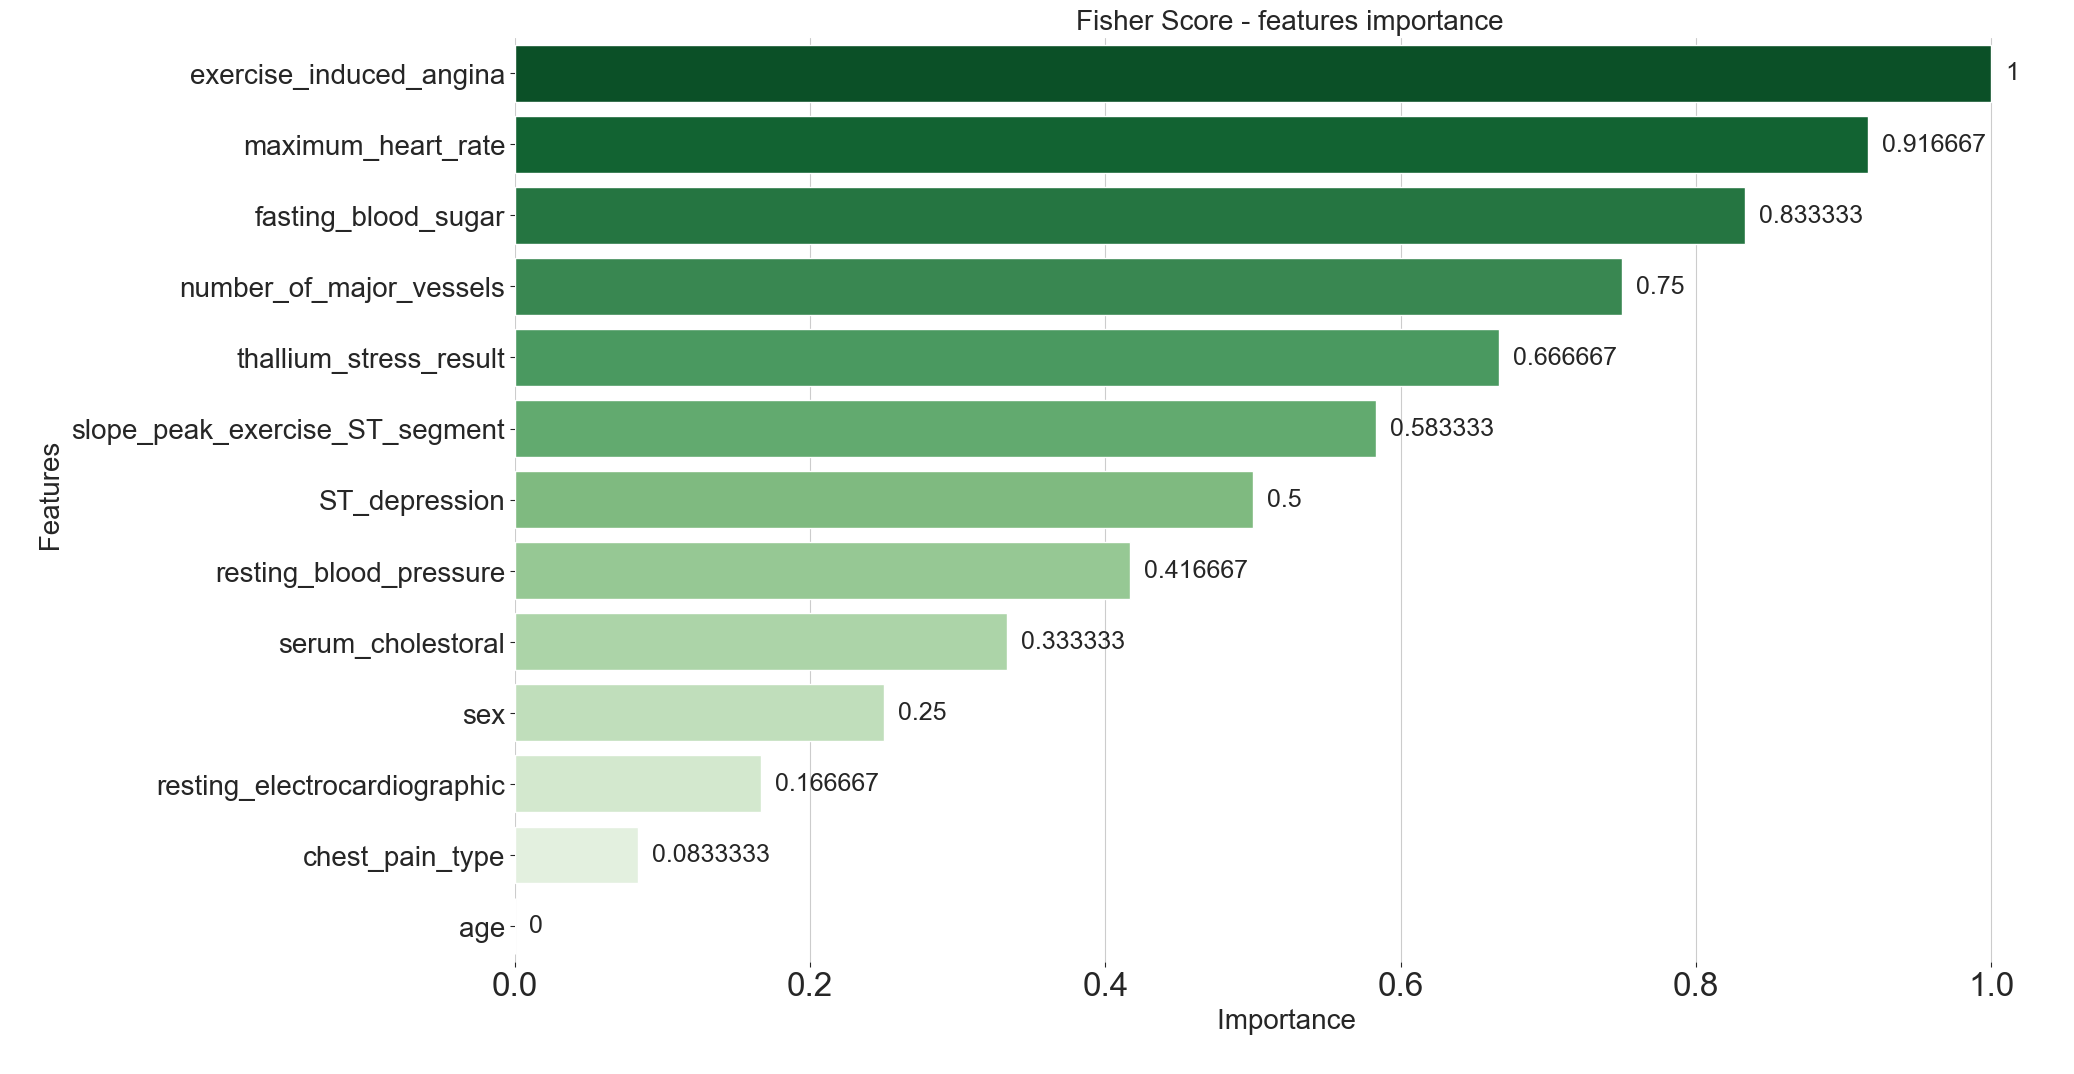

In [10]:
fisher_rank = FeatureRank(fisher_score).get_ranks(X, y)
fisher_rank.plot_scores("Fisher Score - features importance", sorting=True)


#### Comparison


In [31]:
filter_methods_comp = pd.DataFrame(
    data={
        "features": df_train.columns[:-1],
        "mutual_info": mutual_info_rank.rank_result.data["Score"],
        "fisher_score": fisher_rank.rank_result.data["Score"],
    },
)
filter_methods_comp = filter_methods_comp.set_index("features")
# # filter_methods_comp = filter_methods_comp.sort_values(by="mutual_info")
# filter_methods_comp.style.applymap(
#     lambda x: "color: green" if x > 0.3 else "color: red",
# )


### Wrapper methods


#### RFE


<AxesSubplot:title={'center':'RFE Score - feature importance'}, xlabel='Importance \n', ylabel='\n Features'>

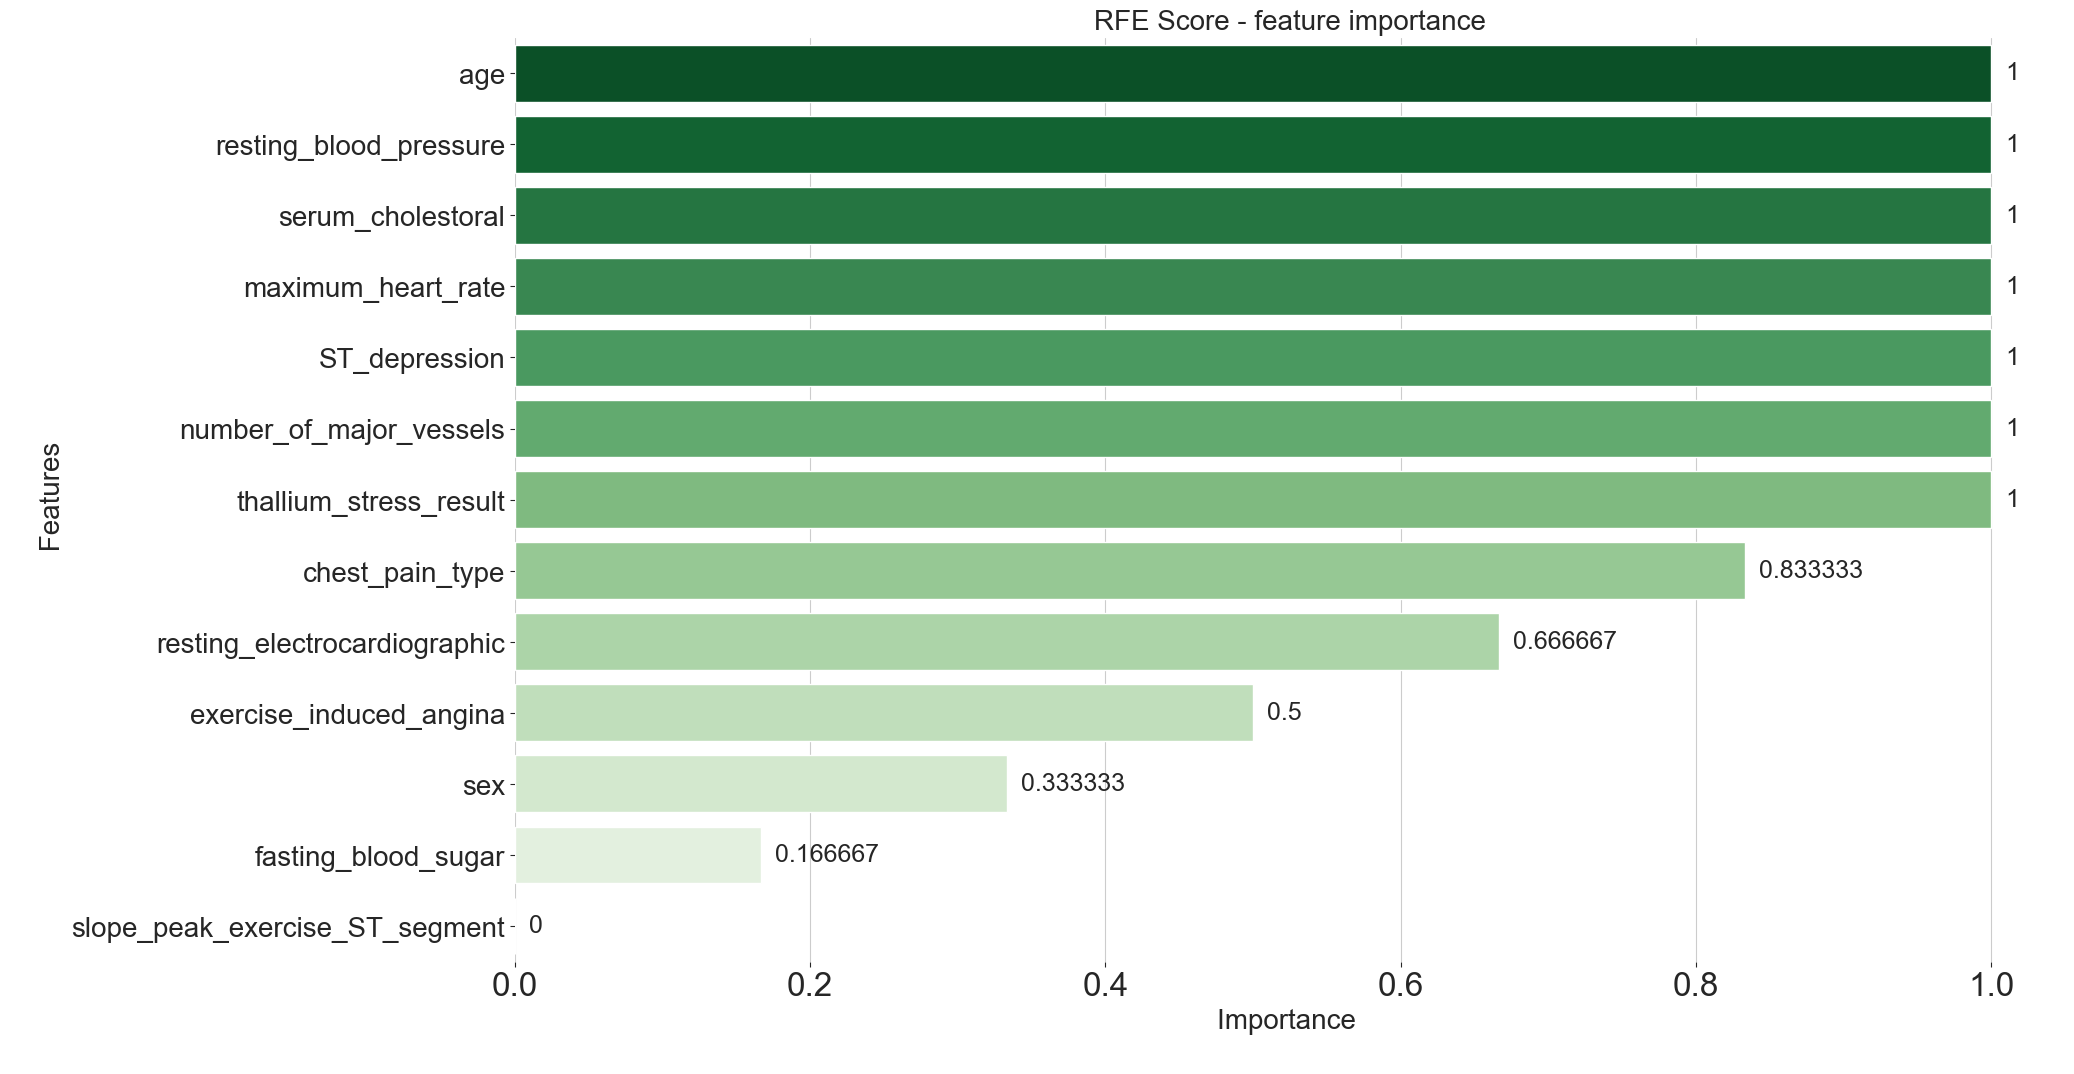

In [32]:
def rfe_score(X, y):
    """Calculate RFE score"""
    dt_classifier = DecisionTreeClassifier(criterion="entropy")
    rfe = RFECV(dt_classifier, step=1, cv=10)
    rfe.fit(X, y)

    scores = abs(rfe.ranking_ - rfe.ranking_.max())
    return scores


rfe_rank = FeatureRank(rfe_score).get_ranks(X, y)
rfe_rank.plot_scores("RFE Score - feature importance", sorting=True)


In [33]:
rfe_rank.get_ranks(X, y)


FeatureRank(score_func=<function rfe_score at 0x0000019D424E60D0>, rank_result=RankResult(specs=Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic', 'maximum_heart_rate', 'exercise_induced_angina', 'ST_depression', 'slope_peak_exercise_ST_segment', 'number_of_major_vessels', 'thallium_stress_result'], dtype='object'), scores=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


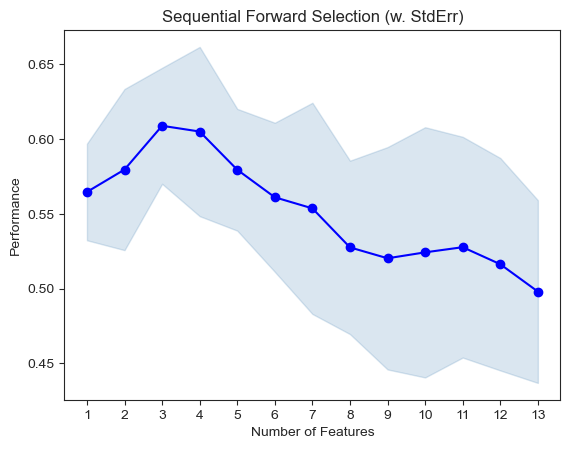

In [34]:
def sfs_score(X, y):
    mlx_sfs_selector = mlx_sfs(
        DecisionTreeClassifier(),
        k_features=X.shape[1],
        forward=True,
        floating=False,
        scoring="accuracy",
        cv=10,
        n_jobs=-1,
    ).fit(X, y)
    # mlx_sfs_features = mlx_sfs_selector.k_feature_names_
    print(mlx_sfs_selector.k_feature_idx_)
    mlx_sfs_scores = mlx_sfs_selector.get_metric_dict()
    return mlx_sfs_scores


# sfs_rank = FeatureRank(sfs_score).get_ranks(df_train.iloc[:, :-1], df_train["target"])
# sfs_rank.plot_scores("SFS Score - feature importance", sorting=True)


fig1 = plot_sequential_feature_selection(sfs_score(X, y), kind="std_dev")
plt.title("Sequential Forward Selection (w. StdErr)")
plt.grid()
plt.show()


#### Genetic Algorithm


In [35]:
genetic_model_selector = GeneticSelectionCV(
    DecisionTreeClassifier(),
    cv=5,
    verbose=1,
    scoring="precision_weighted",
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=10,
)

genetic_model_selector = genetic_model_selector.fit(X, y)
genetic_features = df_train.iloc[:, :-1].columns[genetic_model_selector.support_]


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                               
0  	50    	[ 0.452636  6.22      0.040413]	[ 0.073022  3.941015  0.01892 ]	[ 0.289454  1.        0.00998 ]	[  0.537203  13.         0.088266]
1  	26    	[ 0.506878  8.96      0.042971]	[ 0.020897  2.5374    0.013848]	[ 0.444655  4.        0.018073]	[  0.55242  12.        0.07719]   


KeyboardInterrupt: 

In [ ]:
genetic_features


Index(['sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic', 'maximum_heart_rate', 'ST_depression', 'number_of_major_vessels'], dtype='object')

In [17]:
genetic_model_selector.generation_scores_


array([0.55366962, 0.55894818, 0.55894818, 0.56610293, 0.57518119,
       0.57518119, 0.57518119, 0.58026653, 0.58344877, 0.58026653,
       0.58026653, 0.58654501, 0.58654501, 0.58654501, 0.58654501,
       0.59757648, 0.59757648, 0.59757648, 0.59757648, 0.59757648,
       0.59757648, 0.59757648, 0.59757648, 0.59757648, 0.59757648,
       0.59757648])

### Embedded methods


#### Entropy


<AxesSubplot:title={'center':'Information Gain - features importance'}, xlabel='Importance \n', ylabel='\n Features'>

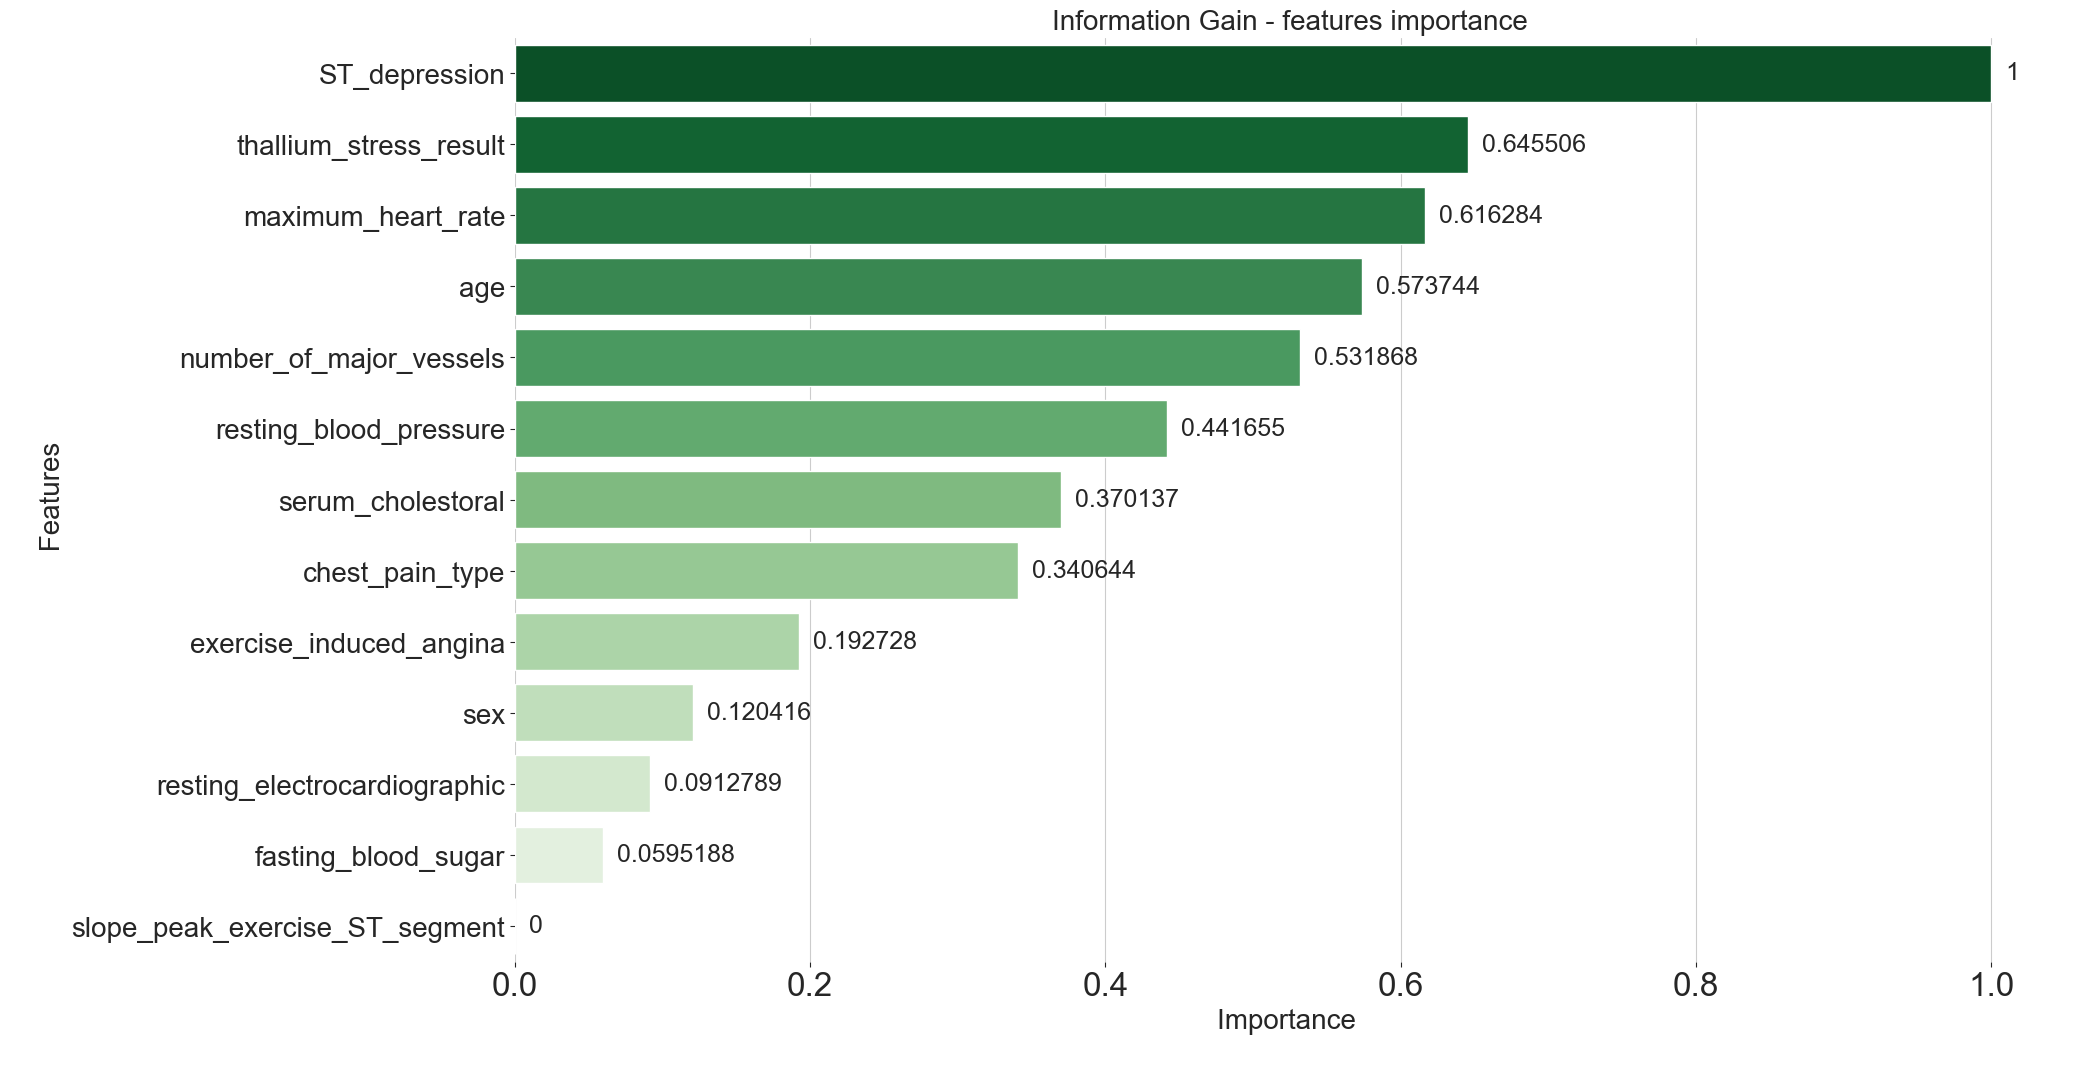

In [36]:
def info_gain_score(X, y):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeClassifier(criterion="entropy")
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_


info_gain_rank = FeatureRank(info_gain_score).get_ranks(X, y)
info_gain_rank.plot_scores(
    "Information Gain - features importance", sorting=True, save=True
)


#### Gini index


<AxesSubplot:title={'center':'Gini Index - features importance'}, xlabel='Importance \n', ylabel='\n Features'>

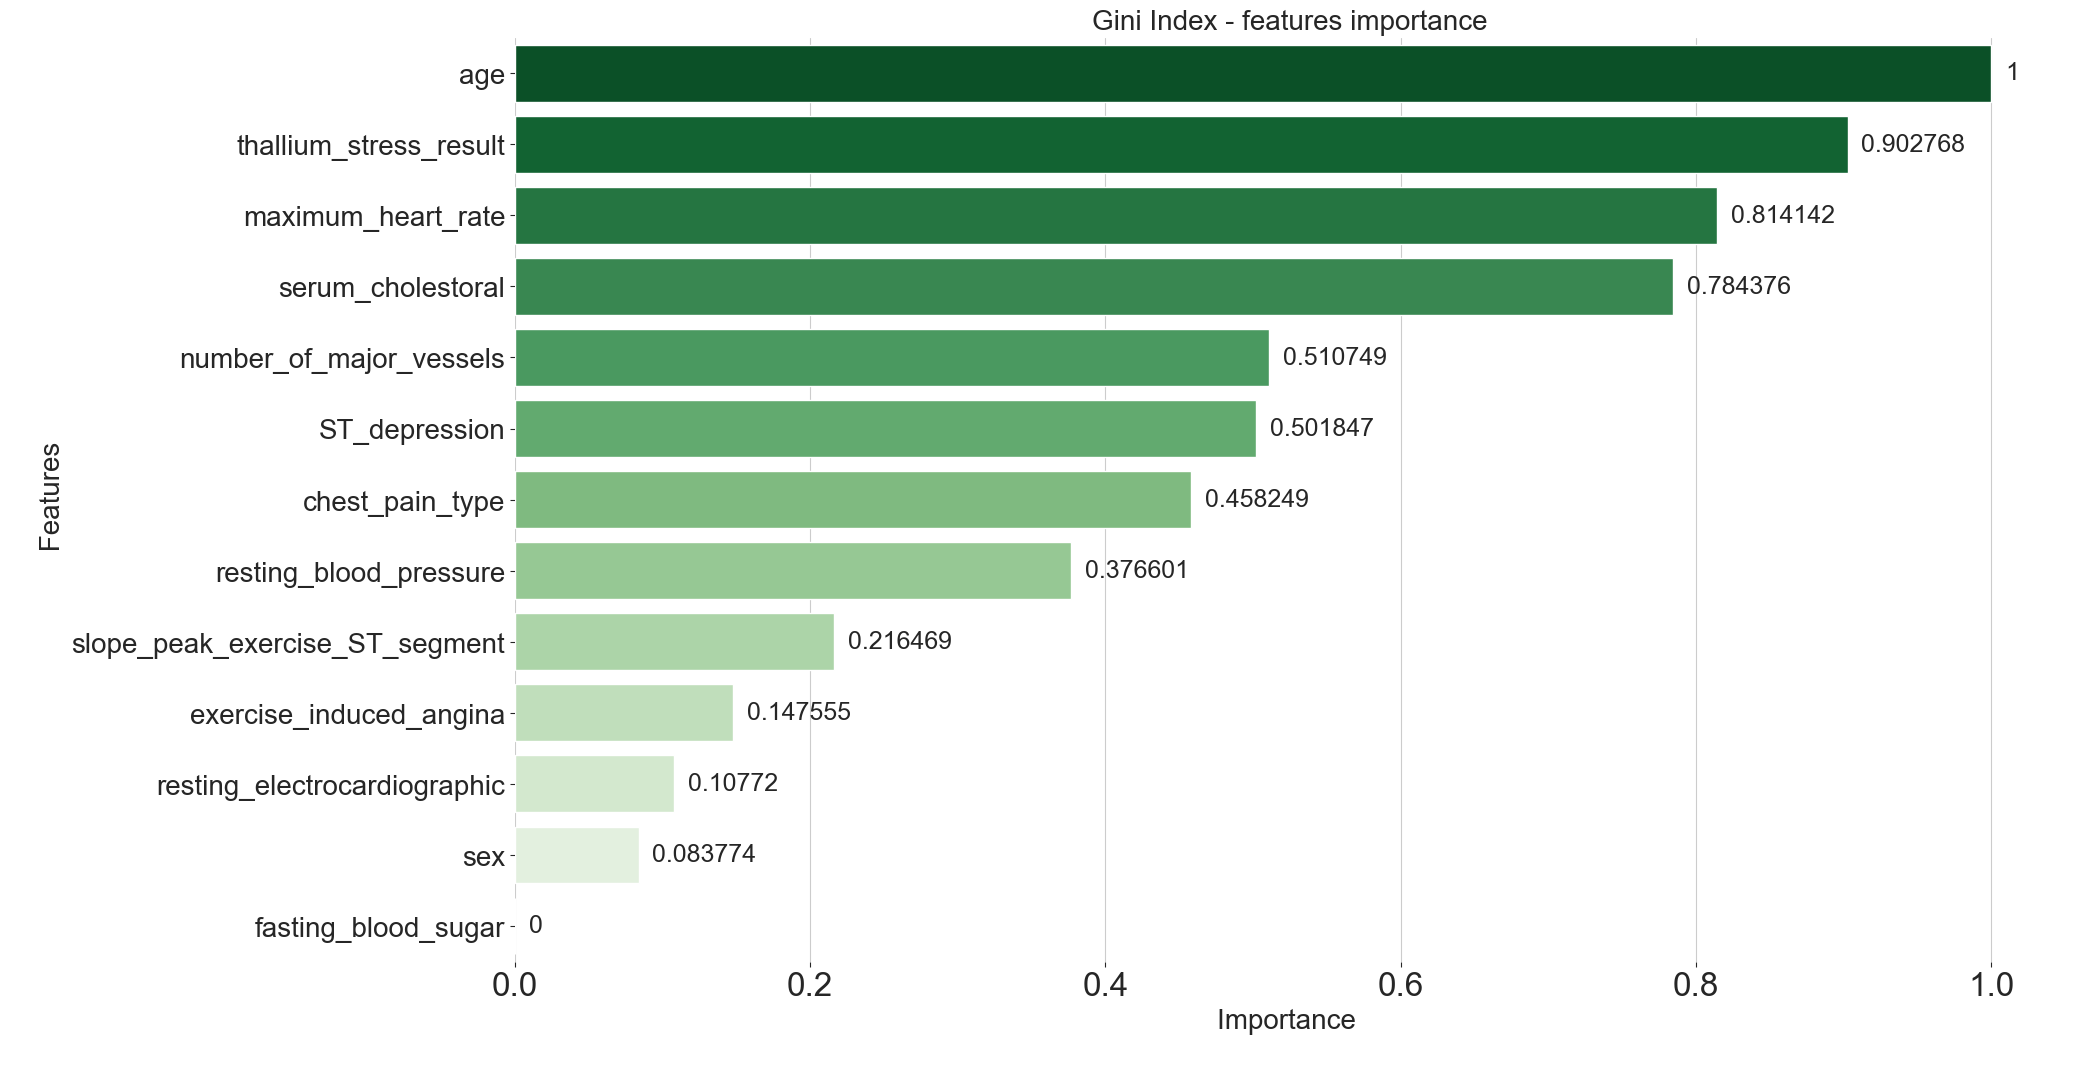

In [37]:
def gini_index_score(X, y):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeClassifier(criterion="gini")
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_


gini_index_rank = FeatureRank(gini_index_score).get_ranks(X, y)
gini_index_rank.plot_scores("Gini Index - features importance", sorting=True, save=True)


#### Lasso (L1 regularization)


<AxesSubplot:title={'center':'Lasso - feature importance'}, xlabel='Importance \n', ylabel='\n Features'>

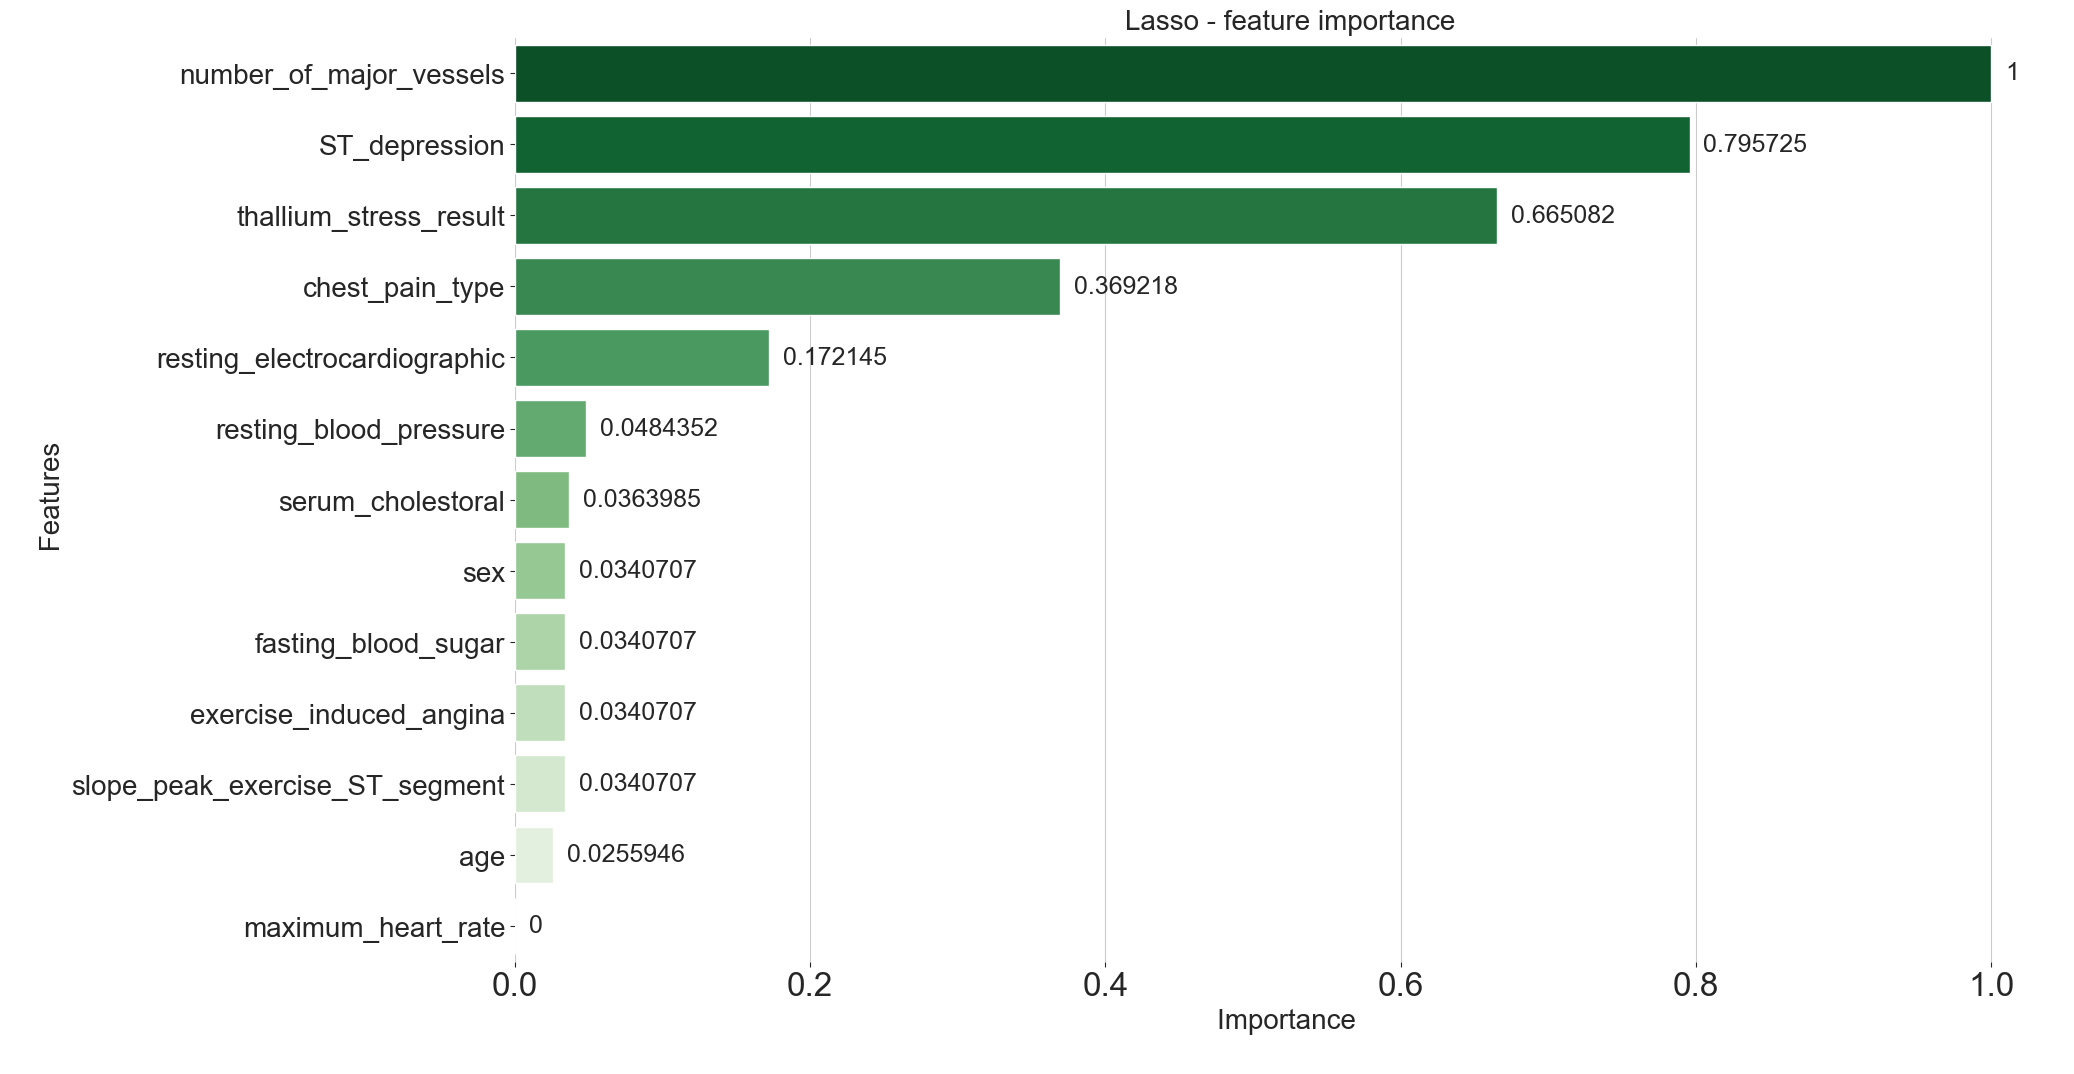

In [38]:
def lasso_score(X, y):
    """Calculate Lasso score"""
    lasso_model_selector = Lasso(alpha=0.1)
    lasso_model_selector.fit(X, y)
    return lasso_model_selector.coef_


lasso_rank = FeatureRank(lasso_score).get_ranks(X, y)
lasso_rank.plot_scores("Lasso - feature importance", sorting=True)


#### Comparison


In [39]:
embedded_methods_comp = pd.DataFrame(
    data={
        "features": df_train.columns[:-1],
        "gini_index": gini_index_rank.rank_result.data["Score"],
        "info_gain": info_gain_rank.rank_result.data["Score"],
        "L1-regularization": lasso_rank.rank_result.data["Score"],
    },
)
embedded_methods_comp = embedded_methods_comp.set_index("features")
# embedded_methods_comp = embedded_methods_comp.sort_values(by="tree_based")
# embedded_methods_comp.style.applymap(
#     lambda x: "color: green" if x > 0.3 else "color: red"
# )


## Important Features

In comparison between graphs and statistical test, the conclusion about the most contribution features are:

- for categorical features:
  1. **slope peak exercise ST segment**
  2. **exercise induced angina**
  3. **chest pain type**
  4. **sex**
- for numerical features:
  1. **max heart rate**
  2. **age**
  3. **ST depression**


In [40]:
filter_embedded_comp = pd.concat([embedded_methods_comp, filter_methods_comp], axis=1)

filter_embedded_comp_styled = filter_embedded_comp.style.applymap(
    lambda x: "color: green" if x > 0.1 else "color: red"
)
filter_embedded_comp_styled


,gini_index,info_gain,L1-regularization,mutual_info,fisher_score
features,,,,,
age,1.0000000000,0.5737437689,0.0255946157,0.0000000000,0.0000000000
sex,0.0837740329,0.1204160266,0.0340706845,0.2111306209,0.2500000000
chest_pain_type,0.4582493579,0.3406443440,0.3692177275,1.0000000000,0.0833333333
resting_blood_pressure,0.3766005156,0.4416551745,0.0484351974,0.1851912398,0.4166666667
serum_cholestoral,0.7843761551,0.3701370217,0.0363984857,0.1173564764,0.3333333333
fasting_blood_sugar,0.0000000000,0.0595187588,0.0340706845,0.3923590251,0.8333333333
resting_electrocardiographic,0.1077204003,0.0912789247,0.1721454935,0.4038798426,0.1666666667
maximum_heart_rate,0.8141420890,0.6162841419,0.0000000000,0.6740606468,0.9166666667
exercise_induced_angina,0.1475545067,0.1927283470,0.0340706845,0.3561657029,1.0000000000


# Balance Data

**Target classes balancing:**

Depending on the the percentage pie chart the target values should be balanced


In [42]:
def plot_balancing(
    data: pd.DataFrame, class_: str, title: str = None, to_image: str = None
):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    sns.countplot(x=class_, data=data, orient="h", ax=ax)

    sns.despine(left=False, bottom=False)
    sns.set_style("ticks", {"axes.grid": True})
    ax.set_xticklabels(["no disease", "LAD", "LCX", "RCA", "highest"])
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("\n Targets", fontsize=18)
    ax.set_ylabel("Record counts \n", fontsize=18)

    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=18)

    ax.bar_label(ax.containers[0], fontsize=18, padding=10)
    plt.grid(axis="x")

    if to_image:
        fig.savefig(FIG_DIR + "balancing/" + to_image, bbox_inches="tight")


In [45]:
def smote_resample(X, y):
    sampler = SMOTE()
    X_res, y_res = sampler.fit_resample(X, y)

    df_blanced_smote = pd.concat([X_res, y_res], axis=1)

    return df_blanced_smote


df_train_blanced_smote = smote_resample(X, y)

# plot_balancing(
#     data=df_train_blanced_smote,
#     class_="target",
#     title="SMOTE",
#     to_image="smote_balance.jpg",
# )


AttributeError: 'NoneType' object has no attribute 'split'

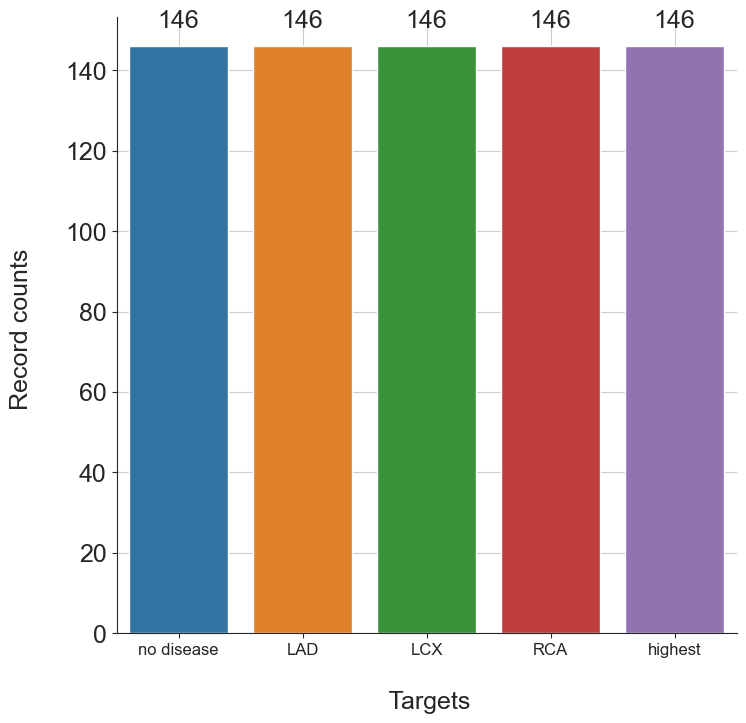

In [ ]:
def ros_resample(X, y):
    sampler = RandomOverSampler(random_state=42)
    X_res, y_res = sampler.fit_resample(X, y)

    df_blanced_ros = pd.concat([X_res, y_res], axis=1)

    return df_blanced_ros


df_train_blanced_ros = ros_resample(X, y)

plot_balancing(
    data=df_train_blanced_ros,
    class_="target",
    to_image="oversampling_balance.jpg",
)
